<a href="https://colab.research.google.com/github/Bitang-Melyen-Tanulok/Csip_Csip/blob/main/Cross_valid_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image
from google.colab import drive

X = []
Y = []
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DeepLearning'


spectrograms_path = os.path.join(path, 'sample_train_spectrograms_20_first_newSg')  # Adott mappa elérési útvonala
folders = os.listdir(spectrograms_path)

for folder in folders:
    print(f"Current folder: {folder}")
    folder_path = os.path.join(spectrograms_path, folder)  # Mappa útvonal

    # Fájlok bejárása a mappában
    files = os.listdir(folder_path)

    for file in files:
        if file.endswith('.png'):  # Csak PNG fájlokat olvasunk be
            file_path = os.path.join(folder_path, file)

            # Kép betöltése
            img = image.load_img(file_path, color_mode='grayscale')
            img_array = image.img_to_array(img)  # Kép tömbbé alakítása
            X.append(img_array)

            # Címke hozzáadása (mappanév alapján)
            Y.append(folder)


X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)
print()
test_split = 0.1
valid_split = 0.1

#shuffle X and Y the same way
permutation = np.random.permutation(len(X))
X = X[permutation]
Y = Y[permutation]

# nb_samples = len(X)
# valid_start_idx = int(nb_samples*(1-valid_split-test_split))
# test_start_idx = int(nb_samples*(1-test_split))

# X_train = X[:valid_start_idx]
# Y_train = Y[:valid_start_idx]
# X_valid = X[valid_start_idx:test_start_idx]
# Y_valid = Y[valid_start_idx:test_start_idx]
# X_test = X[test_start_idx:]
# Y_test = Y[test_start_idx:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current folder: blrwar1
Current folder: categr
Current folder: forwag1
Current folder: grenig1
Current folder: jerbus2
Current folder: insowl1
Current folder: junmyn1
Current folder: lewduc1
Current folder: plaflo1
Current folder: pursun4
Current folder: putbab1
Current folder: redspu1
Current folder: revbul
Current folder: rewlap1
Current folder: rufbab3
Current folder: rutfly6
Current folder: sqtbul1
Current folder: vefnut1
Current folder: barswa
Current folder: rerswa1
(2307, 369, 496, 1)
(2307,)



In [10]:
# #Normalizing data

# X_train = X_train / np.max(X_train)
# X_valid = X_valid / np.max(X_valid)
# X_test = X_test / np.max(X_test)

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#Since this is a multi-class classification task, I am converting labels to one-hot format:

#First, the labels need to be converted into numerical values
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

#Getting number of classes
num_classes = len(le.classes_)
print(f"Class number= {num_classes}")

# Y_train= to_categorical(Y_train_encoded, num_classes)
# Y_valid = to_categorical(Y_valid_encoded, num_classes)
# Y_test = to_categorical(Y_test_encoded, num_classes)

Y_onehot = to_categorical(Y_encoded, num_classes)

Class number= 20


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

#Also implementing early stopping, since there is no reason for it to go through when val_loss isn't decreasing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #If it doesn't improve for 5 epochs, it concludes
    verbose=1,
    restore_best_weights=True
)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

#Wanting to save the best model, so implementing checkpointing
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []

history_per_fold = []

# Start Stratified K-Fold cross-validation
fold_number = 1
for train_index, test_index in skf.split(X, Y_encoded):
  print(f"Startung fold: {fold_number}")

  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y_onehot[train_index], Y_onehot[test_index]

  X_train = X_train / np.max(X_train)
  X_test = X_test / np.max(X_test)

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(
      X_train, Y_train,
      epochs=50,
      batch_size=32,
      validation_data=(X_test, Y_test),
      callbacks=[early_stopping],
      verbose=1
  )

  history_per_fold.append(history)

  test_loss, test_accuracy = model.evaluate(X_test, Y_test)
  print(f"Fold {fold_number} - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

  fold_accuracies.append(test_accuracy)
  fold_losses.append(test_loss)

  fold_number += 1

#To display the model
model.summary()

Startung fold: 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.1823 - loss: 3.8815 - val_accuracy: 0.2554 - val_loss: 2.3631
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.2641 - loss: 2.4744 - val_accuracy: 0.3160 - val_loss: 2.2584
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.3088 - loss: 2.2555 - val_accuracy: 0.3398 - val_loss: 1.9979
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.3946 - loss: 1.9339 - val_accuracy: 0.4394 - val_loss: 1.8917
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.4879 - loss: 1.7308 - val_accuracy: 0.4762 - val_loss: 1.7203
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.5596 - loss: 1.4645 - val_accuracy: 0.4827 - val_loss: 1.7274
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.5671 - loss: 1.3434 - val_accuracy: 0.4892 - val_loss: 1.7731
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.6544 - loss: 1.1391 - val_accura

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 367, 494, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 183, 247, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 181, 245, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 90, 122, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 88, 120, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 44, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 337920)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      43,253,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,047,422 (496.09 MB)

 Trainable params: 43,349,140 (165.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 86,698,282 (330.73 MB)

In [15]:
print("\nCross-Validation Results:")
print(f"Mean Validation Loss: {np.mean(fold_losses)}")
print(f"Mean Validation Accuracy: {np.mean(fold_accuracies)}")


Cross-Validation Results:
Mean Validation Loss: 2.2331430912017822
Mean Validation Accuracy: 0.32286766171455383


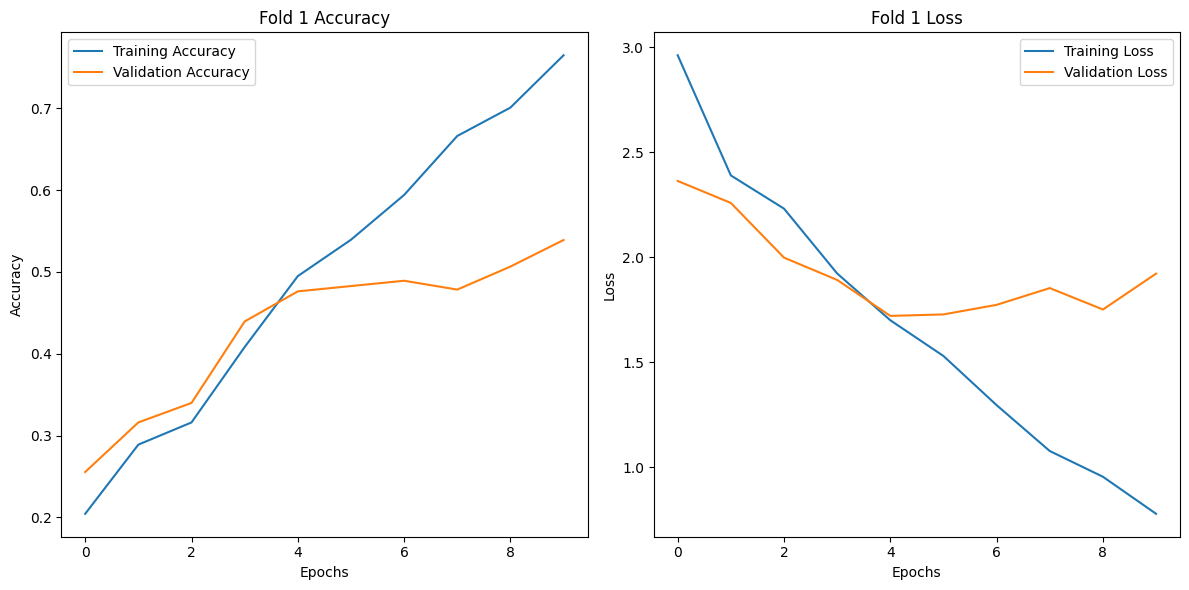

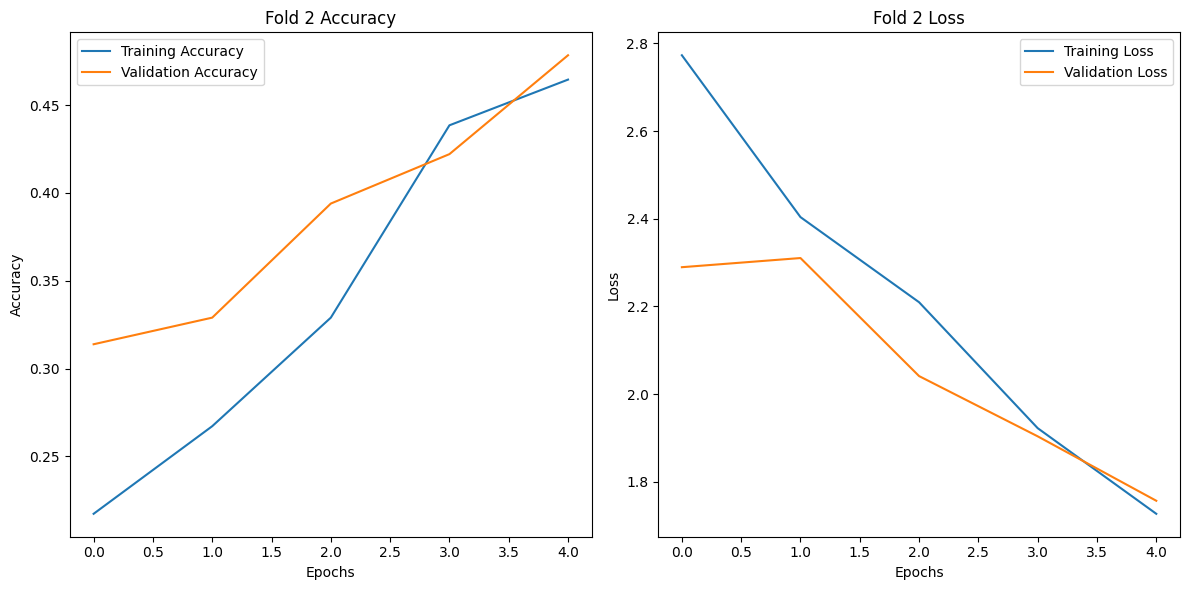

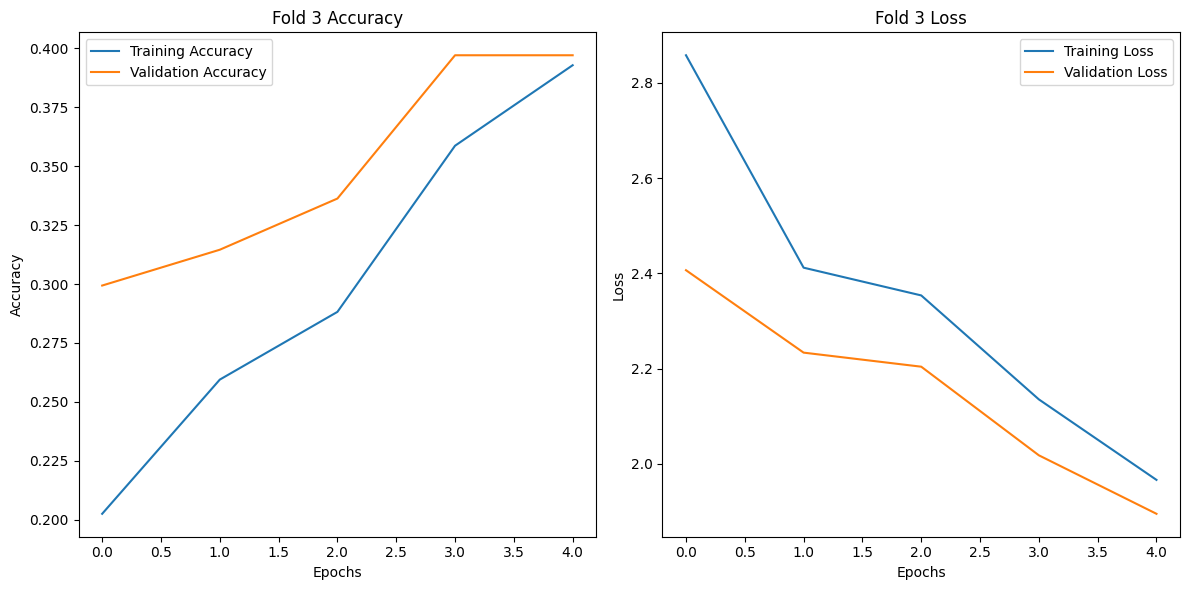

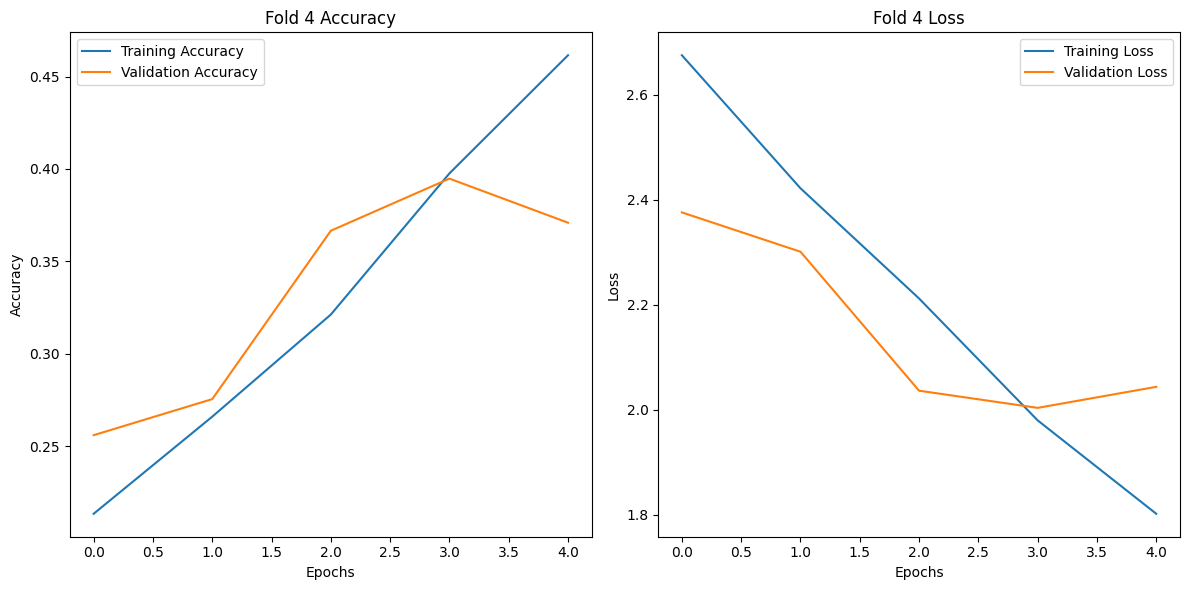

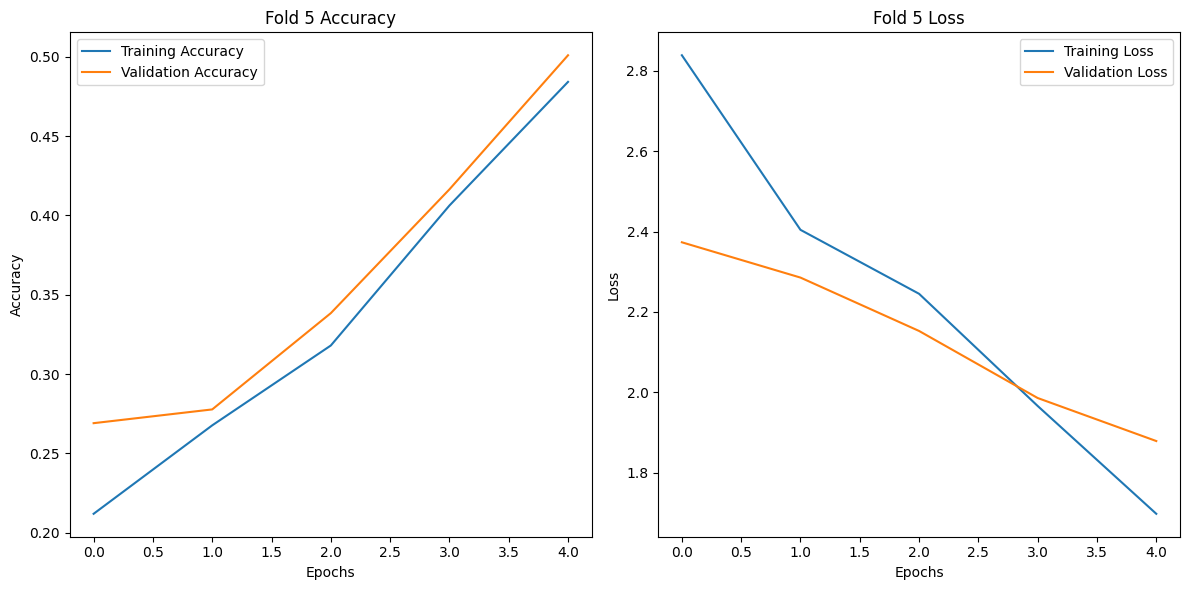

In [16]:
# Plot loss and accuracy for each fold
for i, history in enumerate(history_per_fold):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()